## Simple example of kriging in gempy

In this notebook it will be shown how to create a kriged or simulated field in a simple geological model in gempy. We start by creating a simple model with three horizontally layered units, as shown in the gempy examples.

In [111]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
# just here as it is subfolder in experimental
os.pardir = '../..'

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

# new for this
import importlib
from gempy.assets import kriging

Creating the model by importing the input data and displaying it:

In [2]:
geo_data = gp.create_data([0,1000,0,50,0,1000],resolution=[50,1,50], 
                        path_o = os.pardir+"/data/input_data/jan_models/model1_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


Setting and ordering the units and series:

In [3]:
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [4]:
#%matplotlib inline
#gp.plot.plot_data(geo_data, direction='y')

Calculating the model:

In [5]:
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [6]:
# no mesh computed as basically 2D model
sol = gp.compute_model(geo_data, compute_mesh=False)

So here is the very simple, basically 2D model that we created:

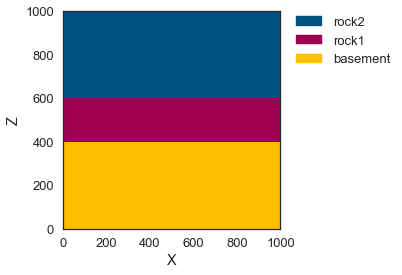

In [7]:
gp.plot.plot_section(geo_data, cell_number=0, show_legend=True, show_data=False)

## 1) Input (conditioning) data

Let us assume we have a couple of measurements in a domain of interest within our model. In our case the unit of interest is the central rock layer ("rock1"). In the kriging module we can define the domain by handing over a number of surfaces by id - in this case the id of rock1 is 2. In addition we define four input data points in cond_data, each defined by x,y,z coordinate and a measurement value.

In [8]:
cond_data = np.array([[100,.5,500,2],[900,.5,500,1],[500,.5,550,1],[300,.5,400,5]])

## 2) Kriging interpolation

In the following we define an object called kriging_model and set all input parameters. Finally we generate the kriged field.

In [170]:
kriging_model = kriging.kriging_model(model=sol, domain=[2],data=cond_data)

In [171]:
kriging_model.range_ = 100
kriging_model.moving_neighbourhood  = 'all'
kriging_model.set_kriging_type('OK')
kriging_model.nugget = 0
kriging_model.sill = 10

In [172]:
# calculating a solution for the kriged field
kriging_model.create_kriged_field()

The result of our calculation is saved in the following dataframe, containing an estimated value and the kriging variance for each point in the grid:

In [173]:
kriging_model.results_df.head()

,X,Y,Z,est_value,est_variance
0,10.0,0.5,410.0,2.194051,10.561915
1,10.0,0.5,430.0,2.172959,10.192955
2,10.0,0.5,450.0,2.150859,9.824946
3,10.0,0.5,470.0,2.130306,9.515096
4,10.0,0.5,490.0,2.114262,9.336440


It is also possible to plot the results in cross section similar to the way gempy models are plotted.

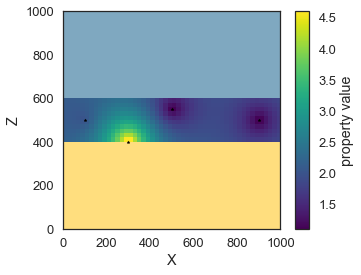

In [174]:
kriging_model.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=0, alpha=.5,
                          legend=True)

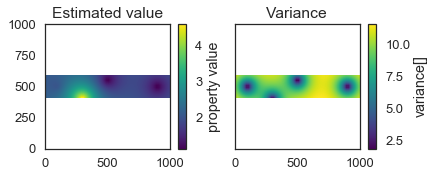

In [175]:
kriging_model.plot_results(geo_data=geo_data, prop='both', contour=False, direction='y', cell_number=0, alpha=0,
                          interpolation='bilinear', show_data=False)

## 2) Simulated field

Based on the same object also a simualted field (stationary Gaussian Field) can be generated. A Sequential Gaussian Simulation approach is applied in this module:

In [176]:
kriging_model.create_gaussian_field()

In [177]:
kriging_model.results_sim_df.head()

,X,Y,Z,sim_value,est_variance
424,10.0,0.5,410.0,2.466791,2.338424
107,10.0,0.5,430.0,3.011713,2.935191
59,10.0,0.5,450.0,2.167077,4.815772
267,10.0,0.5,470.0,5.357785,2.060968
349,10.0,0.5,490.0,5.485648,1.757116


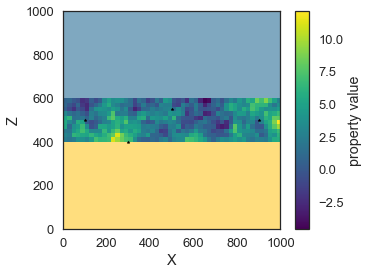

In [178]:
kriging_model.plot_results(geo_data=geo_data, prop='val', result='simulation', contour=False, direction='y', cell_number=0, alpha=.5,
                          legend=True)

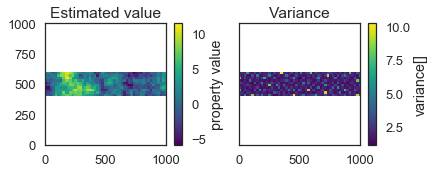

In [168]:
# that is not yet working
kriging_model.plot_results(geo_data=geo_data, prop='both', result='simulation', contour=True, direction='y', cell_number=0, alpha=.5,
                          legend=True)